In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-


import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
"""
Based on Enron data description, its features fall into three major types, 
namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 
'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] 
(all units are in US dollars)

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; 
notable exception is ‘email_address’, which is a text string)

POI label: [‘poi’] (boolean, represented as integer)

For the purpose of analysis, feature "email_address" will be removed and all others will be
added to features_list
"""
features_list = ['poi','salary','deferral_payments','total_payments','loan_advances',
                 'bonus','restricted_stock_deferred','deferred_income','total_stock_value',
                 'expenses','exercised_stock_options','other','long_term_incentive',
                 'restricted_stock','director_fees','to_messages','from_poi_to_this_person',
                 'from_messages','from_this_person_to_poi', 'shared_receipt_with_poi']  # You will need to use more features

### Load the dictionary containing the dataset
data_dict = pickle.load(open("../final_project/final_project_dataset.pkl", "r"))


#### Data Exploration
##### Check how many obs in our data_dict
print len(data_dict.keys())
"""
There are only 146 people's data in this file, and we can 
print their keys(employee names) out to check them visually
"""
sorted(data_dict.keys())
"""
We found that there are two employees name 
called "TOTAL" and "THE TRAVEL AGENCY IN THE PARK".
Both of them are not supposed to be a employee name.
We will remove these two records from our data_dict as outliers"""
##### Take one employee's data as an example to familiar with data
print "Number of Features: ", len(data_dict["ALLEN PHILLIP K"].values())
print data_dict["ALLEN PHILLIP K"]
"""
From the data of employee ALLEN PHILLIP K, we see that not all values have a valid data,
and some values are missing, being filled with "NaN"
In case of any employee's data is all NaN, the followiing code is applied to 
count each employee's missing values and then sorted counts in a descending order
"""
count_NaN = {}
for person, values in data_dict.items(): 
    count = 0
    for feature in features_list:
        if data_dict[person][feature] == 'NaN':
            count = count + 1
        count_NaN.update({person: count})   

sorted(count_NaN.values(), reverse = True)
"""
It returns that the largest number of missing values one employee can have is 19, and then 17
Let's print out their names, count of missing values and original data
Above code is modified to following one to 
"""
count_NaN = {}
for person, values in data_dict.items(): 
    count = 0
    for feature in features_list:
        if data_dict[person][feature] == 'NaN':
            count = count + 1
        count_NaN.update({person: count})   
    if count >= 17:
        print person, "has %d missing values" % count
        print "Here is the original records: "
        print data_dict[person] 
        print "\n"  
"""
The employee LOCKHART EUGENE E has 19 missing values, and 
WHALEY DAVID A, WROBEL BRUCE, LOCKHART EUGENE E, 
THE TRAVEL AGENCY IN THE PARK, GRAMM WENDY L have 17 missing values.
Let's skip record of THE TRAVEL AGENCY IN THE PARK, and check the other 4 employees' data.
We fount that although WHALEY DAVID A, WROBEL BRUCE, LOCKHART EUGENE E, GRAMM WENDY L have
17 missing values in their records, there are still some useful information in their data.
However, employee LOCKHART EUGENE E only has value 'poi': False, this is not useful.
Therfore, this person can also be recogonized as the outlier here.
"""


### Task 2: Remove outliers
#### Remove outlier obs "TOTAL" 
data_dict.pop("TOTAL", 0) 
#### Remove non-employee obs "THE TRAVEL AGENCY IN THE PARK"
data_dict.pop('THE TRAVEL AGENCY IN THE PARK',0)
#### Remove employee with all values missed: "LOCKHART EUGENE E"
data_dict.pop('LOCKHART EUGENE E',0)
#### Change "NaN" to 0
for person in data_dict:
    for feature in features_list:
        if data_dict[person][feature] == "NaN":
            data_dict[person][feature] = 0

"""
After removing outliers, let's see how many people of interest in our data, 
and how much do they consis of our data
"""
count_poi = 0
for person in data_dict.keys():
    if data_dict[person]['poi'] == True:
        count_poi = count_poi + 1
print "Number of People of Interest: ", count_poi
print "Percentage of POI consists in our data: ", float(18)/float(len(data_dict.keys()))*100
"""
We can see that there is a class imbalance problem of this data, so we will use 
stratified shuffle split when creating training and testing data, so that an equal ratio of 
POIs to non-POIs could be found in the training and testing sets.
"""


"""
I wanna create some new variables based on features we have, in order to do a comparison,
let's try a simple classifer, say RandomForestClassifer, to see feature importances with our 
currently haveing features first.
We will first fit the model, and then print out feature importances
"""
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
#### Fit a RandomForestClassifer
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(features, labels)
#### Create a dict to store our feature importances
features_importance = {}
count_feature_importance = 0
count_limit = len(clf.feature_importances_) - 1
for feature in features_list:
    features_importance[feature] = clf.feature_importances_[count_feature_importance]
    if count_feature_importance < count_limit:
        count_feature_importance += 1
#### Print our feature importance dictionary
features_importance        


### Task 3: Create new feature(s)
"""
In this part, 3 new variables are created, all of them are ratios
to_from_poi: meatures for a given persion, how many messages he/she sent to poi 
             compared to those he/she received from poi
to_poi_all: meatures for a given persion, how many messages he/she sent to poi 
             compared to those he/she sent to all other people
from_poi_all: meatures for a given persion, how many messages he/she received from poi 
             compared to those he/she recevied from all other people
"""
employees = data_dict.keys()

for person in employees:
    message_to_poi = float(data_dict[person]['from_this_person_to_poi'])
    message_to_all = float(data_dict[person]['to_messages'])
    message_from_poi = float(data_dict[person]['from_poi_to_this_person'])
    message_from_all = float(data_dict[person]['from_messages'])
    if message_from_poi > 0:  
        data_dict[person]['to_from_poi'] = message_to_poi / message_from_poi
    else:
        data_dict[person]['to_from_poi'] = 0    
    if message_to_all > 0:    
        data_dict[person]['to_poi_all'] = message_to_poi / message_to_all
    else:
        data_dict[person]['to_poi_all'] = 0    
    if message_from_all > 0:
        data_dict[person]['from_poi_all'] = message_from_poi / message_from_all
    else:
        data_dict[person]['from_poi_all'] = 0       
#### One more new variable measuring salary and bonus ratio is created here
    person_salary = float(data_dict[person]['salary'])
    person_bonus = float(data_dict[person]['bonus'])
    if person_bonus > 0:
        data_dict[person]['salary_over_bonus'] = person_salary / person_bonus
    else:
        data_dict[person]['salary_over_bonus'] = 0
#### Add new feature to features_list
features_list.extend(['to_from_poi', 'to_poi_all', 'from_poi_all', 'salary_over_bonus'])


"""
Now, let's fit RandomForestClassifier again and then compare new feature imporances with
our previous ones
"""
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
clf = RandomForestClassifier()
clf.fit(features, labels)
#### Create a dict to store our feature importances
features_importance = {}
count_feature_importance = 0
count_limit = len(clf.feature_importances_) - 1
for feature in features_list:
    features_importance[feature] = clf.feature_importances_[count_feature_importance]
    if count_feature_importance < count_limit:
        count_feature_importance += 1
#### Print our feature importance dictionary
features_importance    


### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html
#### First do data splitting
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42, stratify = labels)

# Provided to give you a starting point. Try a variety of classifiers.
#### Try Gaussian Naive Bayes
print "Gaussian Naive Bayes"
clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print 'precision = ', precision_score(labels_test,pred)
print 'recall = ', recall_score(labels_test,pred)
print "\n"

#### Try Random Forest
print "Random Forest"
clf = RandomForestClassifier()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print 'precision = ', precision_score(labels_test,pred)
print 'recall = ', recall_score(labels_test,pred)
print "\n"

#### Try AdaBoost
print "AdaBoost"
clf = AdaBoostClassifier()  
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print 'precision = ', precision_score(labels_test,pred)
print 'recall = ', recall_score(labels_test,pred)
print "\n"

#### Try Logistic Regression
print "Logistic Regression"
clf = LogisticRegression()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print 'precision = ', precision_score(labels_test,pred)
print 'recall = ', recall_score(labels_test,pred)
print "\n"

#### Try Decision Tree
print "Decision Tree Classifier"
clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print 'precision = ', precision_score(labels_test,pred)
print 'recall = ', recall_score(labels_test,pred)
print "\n"
"""
Based on precision and recall, DecisionTreeClassifier is chosen as final choice
"""

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier

kbest_param = range(1,24)

k_precision_recall_dict = {}

for kbest in kbest_param:
    features_list = ['poi', 
                         'salary', 'deferral_payments', 'total_payments', 'loan_advances', 
                         'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 
                         'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 
                         'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 
                         'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_from_poi', 
                         'to_poi_all', 'from_poi_all', 'salary_over_bonus']
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    selector = SelectKBest(f_classif, k = kbest)
    selector.fit(features, labels)
    indices = selector.get_support(True)
    #### Output selected features and their corresponding scores
    print'k =', kbest
    features_list_selected = ['poi']
    for index in indices:
        print 'features: %s score: %f' % (features_list[index + 1], selector.scores_[index])
        features_list_selected.append(features_list[index + 1])
    features_list = features_list_selected

    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
    #### Using GridSearchCV with a Stratified Shuffle Split to find best parameters
    from sklearn.model_selection import GridSearchCV
    parameters = {'criterion':('gini', 'entropy'), 
                  'max_depth': [1,2,3,4,5],
                  'min_samples_leaf': [1,2,3,4,5],
                  'min_samples_split': [5,10,15,20,25,30,35,40,45,50,55,60]}
    tree = DecisionTreeClassifier()
    sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 42)
    clf = GridSearchCV(tree, parameters, cv = sss)
    clf.fit(features, labels)
    print clf.best_params_
    best_params = clf.best_params_
    
    precision_list = []
    recall_list = []
    for count_fit in range(1,100):
        features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42, stratify = labels)

        clf = DecisionTreeClassifier(min_samples_split = best_params['min_samples_split'], 
                                     criterion = best_params['criterion'], 
                                     max_depth = best_params['max_depth'], 
                                     min_samples_leaf = best_params['min_samples_leaf'])

        clf.fit(features_train, labels_train)
        pred = clf.predict(features_test)
        # ratio of true positives out of all positives (true + false)
        #print 'precision = ', precision_score(labels_test,pred)
        # ratio of true positives out of true positives and false negatives
        #print 'recall = ', recall_score(labels_test,pred)
        precision_list.append(precision_score(labels_test,pred))
        recall_list.append(recall_score(labels_test,pred))
            
    average_precision = sum(precision_list)/len(precision_list)
    average_recall = sum(recall_list)/len(recall_list)
    print average_precision, average_recall
    
    k_precision_recall_dict.update({kbest: {"avg_precision": average_precision,
                                    "avg_recall": average_recall}
                                    })
    print k_precision_recall_dict

k = 1
features: exercised_stock_options score: 24.815080
{'min_samples_split': 5, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1}
1.0 0.5
{1: {'avg_precision': 1.0, 'avg_recall': 0.5}}
k = 2
features: total_stock_value score: 24.182899
features: exercised_stock_options score: 24.815080
{'min_samples_split': 10, 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}
1.0 0.2
{1: {'avg_precision': 1.0, 'avg_recall': 0.5}, 2: {'avg_precision': 1.0, 'avg_recall': 0.19999999999999998}}
k = 3
features: bonus score: 20.792252
features: total_stock_value score: 24.182899
features: exercised_stock_options score: 24.815080
{'min_samples_split': 5, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}
0.25 0.2
{1: {'avg_precision': 1.0, 'avg_recall': 0.5}, 2: {'avg_precision': 1.0, 'avg_recall': 0.19999999999999998}, 3: {'avg_precision': 0.25, 'avg_recall': 0.19999999999999998}}
k = 4
features: salary score: 18.289684
features: bonus score: 20.792252
features: total_stock

{'min_samples_split': 40, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1}
0.0 0.0
{1: {'avg_precision': 1.0, 'avg_recall': 0.5}, 2: {'avg_precision': 1.0, 'avg_recall': 0.19999999999999998}, 3: {'avg_precision': 0.25, 'avg_recall': 0.19999999999999998}, 4: {'avg_precision': 0.38383838383838381, 'avg_recall': 0.076767676767676776}, 5: {'avg_precision': 1.0, 'avg_recall': 0.39999999999999997}, 6: {'avg_precision': 1.0, 'avg_recall': 0.39999999999999997}, 7: {'avg_precision': 1.0, 'avg_recall': 0.39999999999999997}, 8: {'avg_precision': 0.0, 'avg_recall': 0.0}, 9: {'avg_precision': 0.0, 'avg_recall': 0.0}, 10: {'avg_precision': 0.0, 'avg_recall': 0.0}, 11: {'avg_precision': 0.0, 'avg_recall': 0.0}, 12: {'avg_precision': 0.0, 'avg_recall': 0.0}}
k = 13
features: salary score: 18.289684
features: total_payments score: 8.772778
features: loan_advances score: 7.184056
features: bonus score: 20.792252
features: deferred_income score: 11.458477
features: total_stock_value score: 

features: other score: 4.187478
features: long_term_incentive score: 9.922186
features: restricted_stock score: 9.212811
features: director_fees score: 2.126328
features: from_poi_to_this_person score: 5.243450
features: from_this_person_to_poi score: 2.382612
features: shared_receipt_with_poi score: 8.589421
features: to_from_poi score: 2.393827
features: to_poi_all score: 4.094653
features: from_poi_all score: 5.123946
{'min_samples_split': 45, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1}
0.0 0.0
{1: {'avg_precision': 1.0, 'avg_recall': 0.5}, 2: {'avg_precision': 1.0, 'avg_recall': 0.19999999999999998}, 3: {'avg_precision': 0.25, 'avg_recall': 0.19999999999999998}, 4: {'avg_precision': 0.38383838383838381, 'avg_recall': 0.076767676767676776}, 5: {'avg_precision': 1.0, 'avg_recall': 0.39999999999999997}, 6: {'avg_precision': 1.0, 'avg_recall': 0.39999999999999997}, 7: {'avg_precision': 1.0, 'avg_recall': 0.39999999999999997}, 8: {'avg_precision': 0.0, 'avg_recall': 0

{'min_samples_split': 5, 'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1}
0.0 0.0
{1: {'avg_precision': 1.0, 'avg_recall': 0.5}, 2: {'avg_precision': 1.0, 'avg_recall': 0.19999999999999998}, 3: {'avg_precision': 0.25, 'avg_recall': 0.19999999999999998}, 4: {'avg_precision': 0.38383838383838381, 'avg_recall': 0.076767676767676776}, 5: {'avg_precision': 1.0, 'avg_recall': 0.39999999999999997}, 6: {'avg_precision': 1.0, 'avg_recall': 0.39999999999999997}, 7: {'avg_precision': 1.0, 'avg_recall': 0.39999999999999997}, 8: {'avg_precision': 0.0, 'avg_recall': 0.0}, 9: {'avg_precision': 0.0, 'avg_recall': 0.0}, 10: {'avg_precision': 0.0, 'avg_recall': 0.0}, 11: {'avg_precision': 0.0, 'avg_recall': 0.0}, 12: {'avg_precision': 0.0, 'avg_recall': 0.0}, 13: {'avg_precision': 0.0, 'avg_recall': 0.0}, 14: {'avg_precision': 0.0, 'avg_recall': 0.0}, 15: {'avg_precision': 0.0, 'avg_recall': 0.0}, 16: {'avg_precision': 0.0, 'avg_recall': 0.0}, 17: {'avg_precision': 0.0, 'avg_recall': 0.0},

Populating the interactive namespace from numpy and matplotlib


([<matplotlib.axis.XTick at 0x11f92fd90>,
 <a list of 23 Text xticklabel objects>)

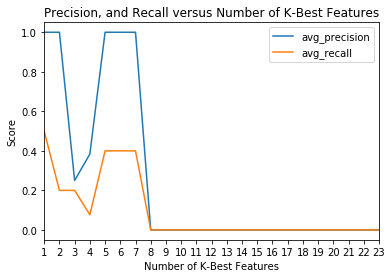

In [18]:
import pandas as pd
k_precision_recall_df = pd.DataFrame.from_dict(data = k_precision_recall_dict, orient='index')

import matplotlib.pyplot as plt
%pylab inline
p_r = k_precision_recall_df[["avg_precision", 'avg_recall']].plot(
    kind = 'line', 
    title = 'Precision, and Recall versus Number of K-Best Features'
    )

plt.xlabel('Number of K-Best Features')
plt.ylabel('Score')
plt.xticks(np.arange(1, 24, 1))

In [16]:
features_list = ['poi', 
                         'salary', 'deferral_payments', 'total_payments', 'loan_advances', 
                         'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 
                         'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 
                         'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 
                         'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_from_poi', 
                         'to_poi_all', 'from_poi_all', 'salary_over_bonus']
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
selector = SelectKBest(f_classif, k = 1)
selector.fit(features, labels)
indices = selector.get_support(True)
#### Output selected features and their corresponding scores
features_list_selected = ['poi']
for index in indices:
    print 'features: %s score: %f' % (features_list[index + 1], selector.scores_[index])
    features_list_selected.append(features_list[index + 1])
features_list = features_list_selected

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = \
train_test_split(features, labels, test_size=0.3, random_state=42, stratify = labels)

clf = DecisionTreeClassifier(min_samples_split = 5, 
                                  criterion = "entropy", 
                                  max_depth = 2, 
                                  min_samples_leaf = 1)

clf.fit(features_train, labels_train)



dump_classifier_and_data(clf, my_dataset, features_list)

features: exercised_stock_options score: 24.815080
